$\newcommand{\vect}[1]{{|#1\rangle}}$
$\newcommand{\vectt}[1]{{\langle#1|}}$
$\newcommand{\x}{\mathbf{x}}$
$\newcommand{\y}{\mathbf{y}}$
$\newcommand{\z}{\mathbf{z}}$
$\newcommand{\s}{\mathbf{s}}$
$\newcommand{\zero}{\mathbf{0}}$
$\newcommand{\one}{\mathbf{1}}$


# Implementing Grover's Algorithm
ECS7011P - Quantum Programming - 2023/24

Chin-Yun Yu

In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_distribution
from typing import List, Tuple, Iterable
from functools import reduce, partial
import matplotlib.pyplot as plt
import math

simulator = AerSimulator(device="GPU")

## Abstract

## Introduction

The way how Grover's algorithm solves the unstructured search problem is in the following steps.
Given a function $f: \{0, 1\}^N \rightarrow \{0, 1\}$, we want to find the value of $x$ such that $f(x) = 1$.
In the context of searching in a database, we want to find the index that exists in the database, whcih is represented by $f$.


## Methodology

Firstly, let's construct $f$ as a unitary operator $U_f$.
The operator $U_f$ is defined as follows:

$
\begin{align}
\mathbf{U}_f (\mathbf{I} \otimes \mathbf{H}) (\vect{\x} \otimes \vect{1})
&= |\x\rangle \otimes \left(\frac{1}{\sqrt{2}} \left(\vect{f(\x)} - \vect{\neg f(\x)}\right)\right) \\
&= (-1)^{f(\x)} |\x\rangle \otimes |-\rangle,
\end{align}
$
where we used the basis state $\vect{-}$ to denote $\frac{1}{\sqrt{2}} (\vect{0} - \vect{1})$.
The detailed derivation can be found in the week 6 lecture slides.
Basically, this operator flips the sign of input $\vect{\x}$ if $f(\x) = 1$, telling us we found the solution.
Let's implement the operator $U_f$ in Qiskit.

In [2]:
def oracle(marked_states: List[str], name="oracle") -> QuantumCircuit:
    """
    Returns a quantum circuit that marks the given states.
    """
    n_bits = len(marked_states[0])

    assert all(
        len(marked_states[0]) == len(state) for state in marked_states
    ), "All marked states must have the same length"

    # allocate n qubits for the input and one for the output
    qc = QuantumCircuit(n_bits + 1, n_bits, name=name)
    qc.barrier()

    # if the input match one of the marked states, the output sign will be flipped
    def f(qc: QuantumCircuit, target: str) -> QuantumCircuit:
        rev_target = target[::-1]
        zero_inds = list(filter(lambda i: rev_target[i] == "0", range(n_bits)))
        # flip the zero bits
        qc.x(zero_inds)
        # flip the sign of |-> if the input is the marked state
        qc.mcx(list(range(n_bits)), n_bits)
        # flip the bits back
        qc.x(zero_inds)
        return qc

    qc = reduce(f, marked_states, qc)
    qc.barrier()
    return qc


example_oracle = oracle(["010", "101"])
example_oracle.draw()

░ ┌───┐     ┌───┐           ░ 
q_0: ─░─┤ X ├──■──┤ X ├──■────────░─
      ░ └───┘  │  ├───┤  │  ┌───┐ ░ 
q_1: ─░────────■──┤ X ├──■──┤ X ├─░─
      ░ ┌───┐  │  ├───┤  │  └───┘ ░ 
q_2: ─░─┤ X ├──■──┤ X ├──■────────░─
      ░ └───┘┌─┴─┐└───┘┌─┴─┐      ░ 
q_3: ─░──────┤ X ├─────┤ X ├──────░─
      ░      └───┘     └───┘      ░ 
c: 3/═══════════════════════════════

In the above example, we built a three bits oracle function that will flip the sign of output register $\vect{-}$ if the input is either $\vect{010}$ or $\vect{101}$.
Here we use the fact that $\mathbf{X}\vect{-} = -\vect{-}$.
But, how can we efficiently found the solution without enumerating all possible inputs?
This is where Grover's algorithm comes in.

### Grover's Algorithm

The algorithm consists of the following steps:

1. Initialize the state to $\vect{\s} = \frac{1}{\sqrt{2^N}} \sum_{\x \in \{0, 1\}^N} \vect{\x} = \mathbf{H}\vect{0\ldots0}$. The output bit is initialized to $\vect{-} = \mathbf{H}\mathbf{X}\vect{0}$.
2. Apply the operator $U_f$ to the input bits.
3. Perform the Grover diffusion operator $\mathbf{H} \mathbf{U}_0 \mathbf{H}$, where $\mathbf{U}_0$ is the zero oracle operator that only flips the sign when the input is $\vect{0\ldots0}$.
4. Repeat steps 2 and 3 for $T$ times, where $T$ is a number depends on the number of solutions and the search space size.

The algorithm increase the probability of getting one of the solutions when we measure the state after step 4.

### Geometrical Interpretation

Let's represent the solution space as a union of two subspaces $\{0, 1\}^N = S \cup \neg S$, where $S = \{\x \in \{0, 1\}^N : f(\x) = 1\}$.
We can use these two sets to define two vectors that are orthogonal to each other.

$
\begin{align}
\vect{Re} = \frac{1}{\sqrt{|\neg S|}} \sum_{\x \in \neg S} \vect{\x},~\
\vect{Im} = \frac{1}{\sqrt{|S|}} \sum_{\x \in S} \vect{\x}.
\end{align}
$

We name the two vectors as the two axis of the complex plane for convenience, which you will see why in a moment, as all the following steps only operate on the unit circle spanned by these two vectors.
The initial state $\vect{s}$ can be written as a linear combination of the two basis vectors:
$
\begin{align}
\vect{\s} = \frac{1}{\sqrt{2^N}} \sum_{\x \in \{0, 1\}^N} \vect{\x} 
&= \frac{1}{\sqrt{|S| + |\neg S|}} \left(\sum_{\x \in S} \vect{\x} + \sum_{\x \in \neg S} \vect{\x}\right) \\
&= \sqrt{\frac{|\neg S|}{2^N}} \vect{Re} + \sqrt{\frac{|S|}{2^N}} \vect{Im}.
\end{align}
$
We can represent it as a complex number using Euler's formula $e^{i\theta_s} = \cos(\theta_s) + i\sin(\theta_s)$ where $\vect{Re} \equiv 1$, $\vect{Im} \equiv i$, and the angle $\theta_s = \sin^{-1}\left(\sqrt{\frac{|S|}{2^N}}\right)$.

#### Interpreting the oracle operator

The oracle operator $U_f$ can be represented as $2 \vect{Re}\vectt{Re} - \mathbf{I}$.
This is easy to see, as the operator flips the sign of the input state if it is in the solution space, and does nothing otherwise.
$
\begin{align}
\mathbf{U}_f \vect{Re} &= 2 \vect{Re}\vectt{Re}\vect{Re} - \vect{Re} = \vect{Re}, \\
\mathbf{U}_f \vect{Im} &= 2 \vect{Re}\vectt{Re}\vect{Im} - \vect{Im} = -\vect{Im}.
\end{align}
$
Using the complex number representation, we can see that the operator $U_f$ taking the conjugate of the input:
$
\begin{equation}
U_f e^{i\theta} = e^{-i\theta}.
\end{equation}
$

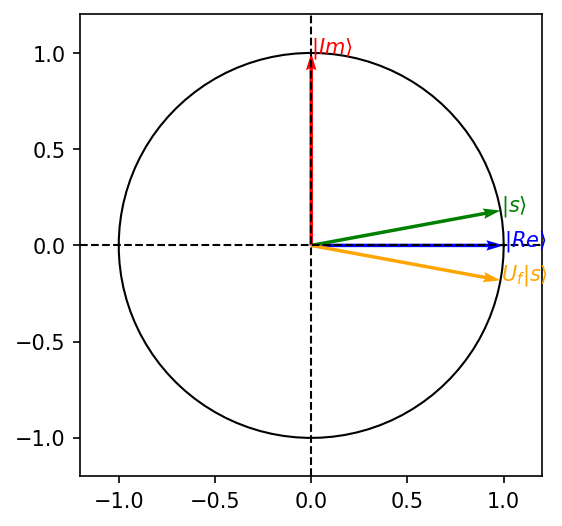

In [3]:
def unit_circle(ax):
    """
    Plots the unit circle on a given axis.
    """
    theta = np.linspace(0, 2 * np.pi, 100)
    x = np.cos(theta)
    y = np.sin(theta)
    ax.plot(x, y, color="black", linewidth=1)
    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(-1.2, 1.2)
    ax.set_aspect("equal", adjustable="box")
    ax.hlines(0, -1.2, 1.2, color="black", linestyle="--", linewidth=1)
    ax.vlines(0, -1.2, 1.2, color="black", linestyle="--", linewidth=1)
    return


def plot_vector(ax, vector: np.ndarray, label: str, color: str):
    """
    Plots a vector on a given axis.
    """
    ax.quiver(
        0, 0, vector[0], vector[1], angles="xy", scale_units="xy", scale=1, color=color
    )
    ax.text(vector[0], vector[1], label, color=color)
    return


theta_s = math.pi * 0.058
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)
unit_circle(ax)
plot_vector(ax, [1, 0], r"$|Re\rangle$", "blue")
plot_vector(ax, [0, 1], r"$|Im\rangle$", "red")
plot_vector(ax, [math.cos(theta_s), math.sin(theta_s)], r"$|s\rangle$", "green")
plot_vector(ax, [math.cos(theta_s), -math.sin(theta_s)], r"$U_f|s\rangle$", "orange")
plt.show()

#### Interpreting the Grover diffusion operator

Similarly, we can represent the zero oracle operator $U_0$ as $2 \vect{0\ldots0}\vectt{0\ldots0} - \mathbf{I}$.
Moreover, 

$
\begin{align}
\mathbf{H} \mathbf{U}_0 \mathbf{H} 
= 2 \mathbf{H} \vect{0\ldots0}\vectt{0\ldots0} \mathbf{H} - \mathbf{H} \mathbf{H} 
= 2 \vect{\s}\vectt{\s} - \mathbf{I}.
\end{align}
$

The form of $2 \vect{\x}\vectt{\x} - \mathbf{I}$ is a reflection operator that reflects the state about the axis $\vect{\x}$. 
This is easy to see as the operator consists of two parts: firstly, $\vect{\x}\vectt{\x}$ projects the input state onto the axis $\vect{\x}$, and then $\vect{\x}\vectt{\x} - \mathbf{I}$ add the difference between the input state and the projection on $\vect{\x}$, equals to the reflection about the axis $\vect{\x}$.
In $U_f$, the axis is the real axis, and the reflection about the real axis is the conjugate operation. 
Because it's a unitary operator, the output state stays on the unit circle.
Only the phase of the state is changed ($\theta_{out} = \theta_x + (\theta_x - \theta_{in}) = 2\theta_x - \theta_{in}$).
Thus, the diffusion operator is:

$
\begin{align}
H U_0 H e^{i\theta} = e^{i(2\theta_s - \theta)}.
\end{align}
$

Let's chain the two operators together and see what happens to the state $\vect{\s}$ in the first iteration:

$
\begin{align}
H U_0 H U_f e^{i\theta_s} = H U_0 H e^{-i\theta_s} = e^{i3\theta_s}.
\end{align}
$
We see the state is rotated by $2\theta_s$ after the first iteration.

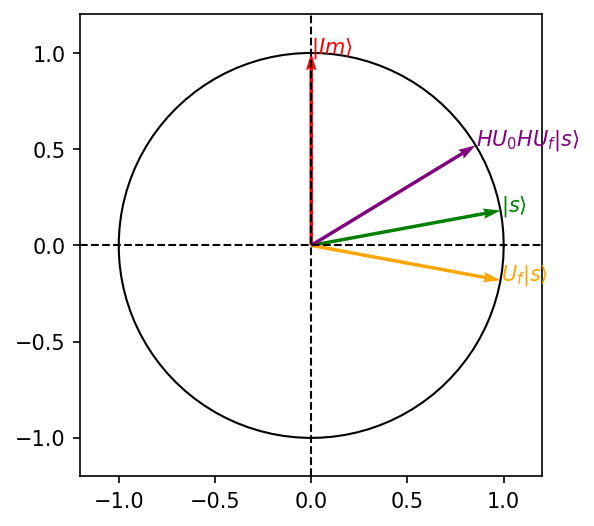

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)
unit_circle(ax)
plot_vector(ax, [0, 1], r"$|Im\rangle$", "red")
plot_vector(ax, [math.cos(theta_s), math.sin(theta_s)], r"$|s\rangle$", "green")
plot_vector(ax, [math.cos(theta_s), -math.sin(theta_s)], r"$U_f|s\rangle$", "orange")
plot_vector(
    ax, [math.cos(3 * theta_s), math.sin(3 * theta_s)], r"$HU_0HU_f|s\rangle$", "purple"
)
plt.show()

Let's apply the operator again and see what happens (we use $U_d = H U_0 H$ for brevity):

$
\begin{align}
U_d U_f e^{i3\theta_s} = U_d e^{-i3\theta_s} = e^{i5\theta_s}.
\end{align}
$

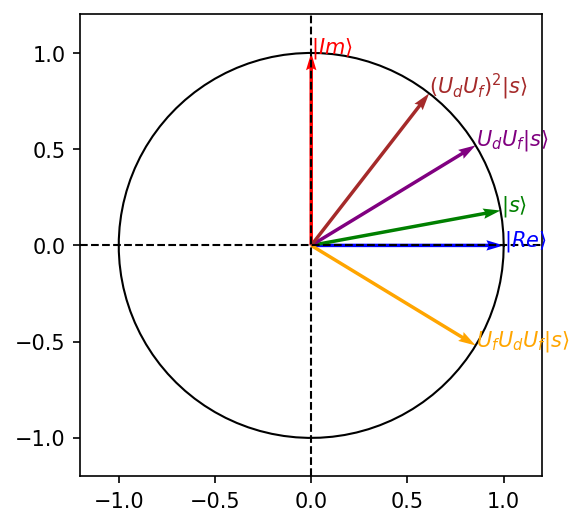

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)
unit_circle(ax)
plot_vector(ax, [1, 0], r"$|Re\rangle$", "blue")
plot_vector(ax, [0, 1], r"$|Im\rangle$", "red")
plot_vector(ax, [math.cos(theta_s), math.sin(theta_s)], r"$|s\rangle$", "green")
plot_vector(
    ax, [math.cos(3 * theta_s), math.sin(3 * theta_s)], r"$U_dU_f|s\rangle$", "purple"
)
plot_vector(
    ax,
    [math.cos(3 * theta_s), -math.sin(3 * theta_s)],
    r"$U_fU_dU_f|s\rangle$",
    "orange",
)
plot_vector(
    ax,
    [math.cos(5 * theta_s), math.sin(5 * theta_s)],
    r"$(U_dU_f)^2|s\rangle$",
    "brown",
)
plt.show()

As the time goes on, the state becomes closer to the solution state $\vect{Im}$ on the imaginary axis, and the probability of measuring the solution state (its projection on the imaginary axis) increases, which is $\sin^2((2T + 1)\theta_s)$ (**question 1**).

## Results

Let's design a toy example to see how Grover's algorithm works.
We'll use a 4-bit oracle function the size of the search space is $2^4 = 16$.
The solution is $\vect{1010}$.

In [6]:
def get_zor(n_bits: int) -> QuantumCircuit:
    return oracle(["0" * n_bits])


def idx2bits(idx: int, n_bits: int) -> str:
    return format(idx, f"0{n_bits}b")


def bits2idx(bits: str) -> int:
    return int(bits, 2)


num_qbits = 4
marked_states = ["1010"]
U_f = oracle(marked_states)
U_f.draw()

░ ┌───┐     ┌───┐ ░ 
q_0: ─░─┤ X ├──■──┤ X ├─░─
      ░ └───┘  │  └───┘ ░ 
q_1: ─░────────■────────░─
      ░ ┌───┐  │  ┌───┐ ░ 
q_2: ─░─┤ X ├──■──┤ X ├─░─
      ░ └───┘  │  └───┘ ░ 
q_3: ─░────────■────────░─
      ░      ┌─┴─┐      ░ 
q_4: ─░──────┤ X ├──────░─
      ░      └───┘      ░ 
c: 4/═════════════════════

The optimal number of iterations $T^*$ is when $\sin^2$ is maximised, which means $(2T^*+1)\theta_s \approx \frac{\pi}{2}$, implies that

$
\begin{align}
T^* = \left\lfloor \frac{\pi}{4\theta_s} - \frac{1}{2} \right\rceil = \left\lfloor \frac{\pi}{4\sin^{-1}\left(\sqrt{\frac{|S|}{2^N}}\right)} \right\rfloor.
\end{align}
$

When only one solution is present ($|S| = 1$), we can approximate $\sin^{-1}(\sqrt{\frac{1}{2^N}}) \approx 2^{-\frac{N}{2}}$ using the fact that $\lim_{x \rightarrow 0} \frac{\sin^{-1}(x)}{x} = 1$ when $N$ is large.
Therefore, the optimal number of iterations is $T^* \approx \pi 2^{\frac{N}{2} - 2} $.
For $N = 4$, $T^* = \lfloor \pi \rfloor = 3$.

In [7]:
def num_iters(n_bits: int, n_marked: int = 1) -> int:
    if n_marked > 1:
        return int(math.pi * 0.25 / math.asin(math.sqrt(n_marked / 2**n_bits)))
    return int(math.pi * 2 ** (n_bits / 2 - 2))


iters = num_iters(num_qbits, len(marked_states))
print(f"T = {iters}")

T = 3


Let's construct the whole algorithm as a quantum circuit and see how it works.
We measure the input registers at the end to see if we get the solution state.

In [8]:
def apply_grovers(U_f: QuantumCircuit, n_iters: int) -> QuantumCircuit:
    n_bits = U_f.num_qubits - 1
    qc = QuantumCircuit(n_bits + 1, n_bits)
    # initialize the state to all zeros
    qc.initialize("0" * (n_bits + 1))
    # negate the last qubit for sign flip
    qc.x(n_bits)
    # apply hadamard to all qubits
    qc.h(range(n_bits + 1))

    diffuser = QuantumCircuit(n_bits + 1, n_bits, name="diffuser")
    diffuser.h(range(n_bits))
    U_zero = oracle(["0" * n_bits], name="diffuser")
    diffuser.compose(U_zero, inplace=True)
    diffuser.h(range(n_bits))

    def iter(qc: QuantumCircuit) -> QuantumCircuit:
        # apply U_f
        qc.compose(U_f, inplace=True)
        # Grover's diffusion operator
        qc.compose(diffuser, inplace=True)
        return qc

    qc = reduce(lambda x, _: iter(x), range(n_iters), qc)
    return qc


full_grovers_qc = apply_grovers(oracle(marked_states), iters)
full_grovers_qc.measure(range(num_qbits), range(num_qbits))
# full_grovers_qc.save_statevector()
full_grovers_qc.draw()

┌────────────────────────┐┌───┐      ░ ┌───┐     ┌───┐ ░ ┌───┐ ░ ┌───┐»
q_0: ┤0                       ├┤ H ├──────░─┤ X ├──■──┤ X ├─░─┤ H ├─░─┤ X ├»
     │                        │├───┤      ░ └───┘  │  └───┘ ░ ├───┤ ░ ├───┤»
q_1: ┤1                       ├┤ H ├──────░────────■────────░─┤ H ├─░─┤ X ├»
     │                        │├───┤      ░ ┌───┐  │  ┌───┐ ░ ├───┤ ░ ├───┤»
q_2: ┤2 Initialize(0,0,0,0,0) ├┤ H ├──────░─┤ X ├──■──┤ X ├─░─┤ H ├─░─┤ X ├»
     │                        │├───┤      ░ └───┘  │  └───┘ ░ ├───┤ ░ ├───┤»
q_3: ┤3                       ├┤ H ├──────░────────■────────░─┤ H ├─░─┤ X ├»
     │                        │├───┤┌───┐ ░      ┌─┴─┐      ░ └───┘ ░ └───┘»
q_4: ┤4                       ├┤ X ├┤ H ├─░──────┤ X ├──────░───────░──────»
     └────────────────────────┘└───┘└───┘ ░      └───┘      ░       ░      »
c: 4/══════════════════════════════════════════════════════════════════════»
                                                                           »
«          ┌───┐ ░ ┌───┐ ░ ┌───┐     ┌───┐ ░ ┌───┐ ░ ┌───┐     ┌───┐ ░ ┌───┐ ░ »
«q_0: ──■──┤ X ├─░─┤ H ├─░─┤ X ├──■──┤ X ├─░─┤ H ├─░─┤ X ├──■──┤ X ├─░─┤ H ├─░─»
«       │  ├───┤ ░ ├───┤ ░ └───┘  │  └───┘ ░ ├───┤ ░ ├───┤  │  ├───┤ ░ ├───┤ ░ »
«q_1: ──■──┤ X ├─░─┤ H ├─░────────■────────░─┤ H ├─░─┤ X ├──■──┤ X ├─░─┤ H ├─░─»
«       │  ├───┤ ░ ├───┤ ░ ┌───┐  │  ┌───┐ ░ ├───┤ ░ ├───┤  │  ├───┤ ░ ├───┤ ░ »
«q_2: ──■──┤ X ├─░─┤ H ├─░─┤ X ├──■──┤ X ├─░─┤ H ├─░─┤ X ├──■──┤ X ├─░─┤ H ├─░─»
«       │  ├───┤ ░ ├───┤ ░ └───┘  │  └───┘ ░ ├───┤ ░ ├───┤  │  ├───┤ ░ ├───┤ ░ »
«q_3: ──■──┤ X ├─░─┤ H ├─░────────■────────░─┤ H ├─░─┤ X ├──■──┤ X ├─░─┤ H ├─░─»
«     ┌─┴─┐└───┘ ░ └───┘ ░      ┌─┴─┐      ░ └───┘ ░ └───┘┌─┴─┐└───┘ ░ └───┘ ░ »
«q_4: ┤ X ├──────░───────░──────┤ X ├──────░───────░──────┤ X ├──────░───────░─»
«     └───┘      ░       ░      └───┘      ░       ░      └───┘      ░       ░ »
«c: 4/═════════════════════════════════════════════════════════════════════════»
«                                                                              »
«     ┌───┐     ┌───┐ ░ ┌───┐ ░ ┌───┐     ┌───┐ ░ ┌───┐┌─┐         
«q_0: ┤ X ├──■──┤ X ├─░─┤ H ├─░─┤ X ├──■──┤ X ├─░─┤ H ├┤M├─────────
«     └───┘  │  └───┘ ░ ├───┤ ░ ├───┤  │  ├───┤ ░ ├───┤└╥┘┌─┐      
«q_1: ───────■────────░─┤ H ├─░─┤ X ├──■──┤ X ├─░─┤ H ├─╫─┤M├──────
«     ┌───┐  │  ┌───┐ ░ ├───┤ ░ ├───┤  │  ├───┤ ░ ├───┤ ║ └╥┘┌─┐   
«q_2: ┤ X ├──■──┤ X ├─░─┤ H ├─░─┤ X ├──■──┤ X ├─░─┤ H ├─╫──╫─┤M├───
«     └───┘  │  └───┘ ░ ├───┤ ░ ├───┤  │  ├───┤ ░ ├───┤ ║  ║ └╥┘┌─┐
«q_3: ───────■────────░─┤ H ├─░─┤ X ├──■──┤ X ├─░─┤ H ├─╫──╫──╫─┤M├
«          ┌─┴─┐      ░ └───┘ ░ └───┘┌─┴─┐└───┘ ░ └───┘ ║  ║  ║ └╥┘
«q_4: ─────┤ X ├──────░───────░──────┤ X ├──────░───────╫──╫──╫──╫─
«          └───┘      ░       ░      └───┘      ░       ║  ║  ║  ║ 
«c: 4/══════════════════════════════════════════════════╩══╩══╩══╩═
«                                                       0  1  2  3

The probability the algorithm finds the solution after three iterations is $\sin^2(7\theta_s) = (-\sin(\theta_s) (56\sin^2(\theta_s) - 112 \sin^4(\theta) -7 + 64\sin^6(\theta_s)))^2$. Let's see what's the exact number of it.

In [46]:
seven_angle_sin = partial(np.polyval, [-64, 0, 112, 0, -56, 0, 7, 0])

print(
    f"The probability of finding the solution with T = 3 is {seven_angle_sin(0.25) ** 2}"
)

The probability of finding the solution with T = 3 is 0.9613189697265625


Result(backend_name='aer_simulator', backend_version='0.13.3', qobj_id='', job_id='4c035e69-ab6b-48d1-9383-aeeda71a5cd4', success=True, results=[ExperimentResult(shots=1000, success=True, meas_level=2, data=ExperimentResultData(counts={'0xb': 1, '0xf': 3, '0xa': 958, '0x7': 1, '0x3': 4, '0x2': 4, '0x0': 2, '0xc': 2, '0x8': 3, '0x6': 3, '0xd': 1, '0x4': 2, '0x9': 2, '0x5': 4, '0xe': 6, '0x1': 4}), header=QobjExperimentHeader(creg_sizes=[['c', 4]], global_phase=0.0, memory_slots=4, n_qubits=5, name='circuit-167', qreg_sizes=[['q', 5]], metadata={}), status=DONE, seed_simulator=2270108628, metadata={'time_taken': 4.45947157, 'num_bind_params': 1, 'parallel_state_update': 1, 'parallel_shots': 20, 'required_memory_mb': 1, 'input_qubit_map': [[4, 4], [3, 3], [2, 2], [1, 1], [0, 0]], 'max_gpu_memory_mb': 6143, 'method': 'statevector', 'device': 'GPU', 'num_qubits': 5, 'gpu_parallel_shots_': 1, 'active_input_qubits': [0, 1, 2, 3, 4], 'num_clbits': 4, 'remapped_qubits': False, 'runtime_paramete

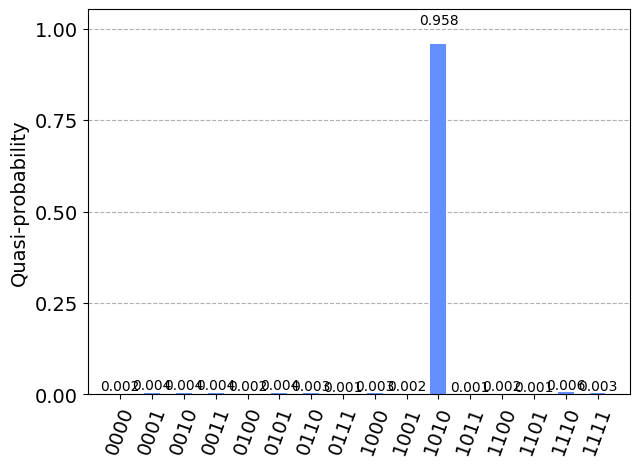

In [11]:
results = simulator.run(full_grovers_qc, shots=1000).result()
print(results)
answer = results.get_counts()
counts2probs = lambda counts: (
    lambda scaler: {k: v / scaler for k, v in counts.items()}
)(sum(counts.values()))
probs = counts2probs(answer)
plot_distribution(probs)

After sampling 1000 times, we can see that the probability of finding $\vect{1010}$ is very close to 0.96, which is consistent with the theoretical prediction.

### What happen when T is not optimal (**question 2**)?

We have shown that the probabiliy $\sin^2((2T + 1)\theta_s): T \in \left[0, \lfloor\frac{\pi}{2\theta_s} - \frac{1}{2}\rfloor\right]$ is maximised when $T = T^*$.
Any $T \neq T^*$ will result in a lower probability of finding the solution.

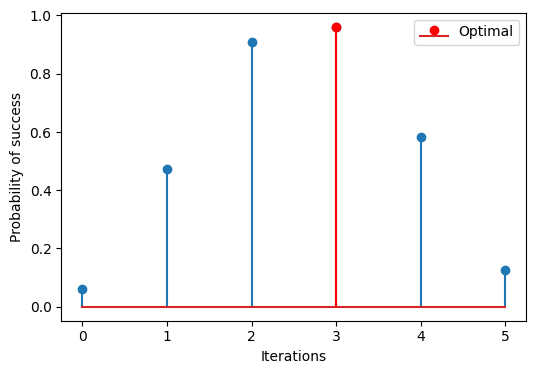

In [49]:
five_angle_sin = partial(np.polyval, [16, 0, -20, 0, 5, 0])
n_angle_sin = lambda sina, n: (((1 - sina**2) ** 0.5 + 1j * sina) ** n).imag

t = list(range(int(math.pi / 2 / math.asin(0.25) - 0.5) + 1))
y = list(
    map(lambda x: x * x, map(partial(n_angle_sin, 0.25), map(lambda x: 2 * x + 1, t)))
)
fig = plt.figure(figsize=(6, 4), dpi=100)
plt.stem(t, y)
plt.stem([iters], [seven_angle_sin(0.25) ** 2], "r", label="Optimal")
plt.xlabel("Iterations")
plt.ylabel("Probability of success")
plt.legend()
plt.show()

 Because $\sin^2$ is periodic with period $\pi$, we could find other $T > T^*$ that gives high probability.
 Let's see what happens when $T = 9$.

In [44]:
print(
    f"The probability of finding the solution with T = 9 is {n_angle_sin(0.25, 19)**2}"
)

The probability of finding the solution with T = 9 is 0.9921818600205397


Although the probability is higher than the case of $T^* = 3$, it needs more iterations to reach that.

### Relation to _inversion of the mean_ operator (**question 3**)

## References

[^1]: https://learn.microsoft.com/en-us/azure/quantum/concepts-grovers#geometrical-explanation